In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA, KernelPCA

import sys
sys.path.append("../") # go to parent dir

from src.debiasing import DebiasingPCA
from src.debiasing import DebiasingKPCA
from src.debiasing import NumpyDebiasingKernelPCA
from src.debiasing.utils import get_design_matrix

In [2]:
data = pd.read_csv("../data/CoLA/mixed_dev_embeddings.tsv", sep="\t")
data = data.sort_values(by='defining set id')
X = data.iloc[:, 3:771].to_numpy()
X_index = data['defining set id'].to_numpy()

In [3]:
print("the shape of X:", X.shape)
X

the shape of X: (640, 768)


array([[-0.851718  , -0.4793546 , -0.77166116, ..., -0.5383287 ,
        -0.76654   ,  0.9239464 ],
       [-0.84405816, -0.49862942, -0.7877743 , ..., -0.57809174,
        -0.728355  ,  0.9136135 ],
       [-0.87432224, -0.59713227, -0.9513105 , ..., -0.40138096,
        -0.7750305 ,  0.8731641 ],
       ...,
       [-0.886508  , -0.51329815, -0.94088244, ..., -0.75856566,
        -0.7137282 ,  0.9045762 ],
       [-0.70865357, -0.30252996, -0.819484  , ..., -0.36328802,
        -0.6049608 ,  0.7728163 ],
       [-0.7912138 , -0.4454564 , -0.92030555, ..., -0.6560643 ,
        -0.64869297,  0.8218555 ]])

In [4]:
print("the shape of X_ index:", X_index.shape)
X_index

the shape of X_ index: (640,)


array([  0,   0,   1,   1,   2,   2,   3,   3,   4,   4,   5,   5,   6,
         6,   7,   7,   8,   8,   9,   9,  10,  10,  11,  11,  12,  12,
        13,  13,  14,  14,  15,  15,  16,  16,  17,  17,  18,  18,  19,
        19,  20,  20,  21,  21,  22,  22,  23,  23,  24,  24,  25,  25,
        26,  26,  27,  27,  28,  28,  29,  29,  30,  30,  31,  31,  32,
        32,  33,  33,  34,  34,  35,  35,  36,  36,  37,  37,  38,  38,
        39,  39,  40,  40,  41,  41,  42,  42,  43,  43,  44,  44,  45,
        45,  46,  46,  47,  47,  48,  48,  49,  49,  50,  50,  51,  51,
        52,  52,  53,  53,  54,  54,  55,  55,  56,  56,  57,  57,  58,
        58,  59,  59,  60,  60,  61,  61,  62,  62,  63,  63,  64,  64,
        65,  65,  66,  66,  67,  67,  68,  68,  69,  69,  70,  70,  71,
        71,  72,  72,  73,  73,  74,  74,  75,  75,  76,  76,  77,  77,
        78,  78,  79,  79,  80,  80,  81,  81,  82,  82,  83,  83,  84,
        84,  85,  85,  86,  86,  87,  87,  88,  88,  89,  89,  9

Text(0.5, 0, 'the number of components')

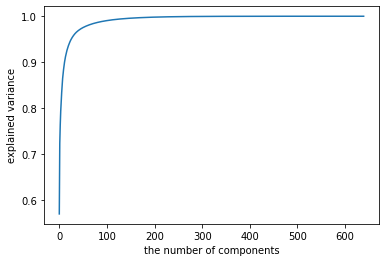

In [5]:
# data visualization
eigvals = PCA().fit(X).explained_variance_
explained_var = np.cumsum(eigvals) / np.sum(eigvals)
plt.plot(explained_var)
plt.ylabel('explained variance')
plt.xlabel('the number of components')

# PCA debiasing

In [6]:
debiaser = DebiasingPCA(n_components=3)
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [7]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(327.869283572284, 426.1726765040533, 272.25885309467145)

# Kernel PCA debiasing (by optimization-based pre-imaging)

### With gradient descent (not great results)

In [8]:
debiaser = DebiasingKPCA(n_components=2)
debiaser.fit(X, X_index)

# to prevent out of memory error, we split the data into smaller chanks
X_debiased = np.empty(X.shape)
BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
for i in range(NB):
    X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=0.4, n_iter=40)

../src/debiasing/torch_kpca.py:235: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


In [9]:
# Euclidean norms in original space
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(426.09609382955483, 426.1726765040533, 18.56138004761513)

In [10]:
# Variations in the latent space (space of kernelized principal components)
np.linalg.norm(debiaser.transform(X_debiased)), np.linalg.norm(debiaser.transform(X))

(7.259435491978974, 9.299421805879149)

### Comparison with PCA in Kernel space

In [11]:
pca_debiaser = DebiasingPCA(1)
pca_debiaser.fit(X, X_index)
X_debiased = pca_debiaser.debias(X)

In [12]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(372.82486163269635, 426.1726765040533, 206.4576778596267)

In [13]:
np.linalg.norm(debiaser.transform(X_debiased)), np.linalg.norm(debiaser.transform(X))

(9.145223297038804, 9.299421805879149)

### Heuristics of Jumping in the first step (with great results)

In [14]:
debiaser = DebiasingKPCA(n_components=3)
debiaser.fit(X, X_index)

# to prevent out of memory error, we aplit the data into smaller chanks
X_debiased = np.empty(X.shape)
BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
for i in range(NB):
    X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=100, n_iter=1)
    X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X_debiased[BS*i: BS*(i+1)], lr=0.3, n_iter=10)

../src/debiasing/torch_kpca.py:235: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


In [15]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(501.8966650870432, 426.1726765040533, 218.1508026901039)

In [16]:
np.linalg.norm(debiaser.transform(X_debiased)), np.linalg.norm(debiaser.transform(X))

(1.270402079288094, 14.081595436343203)

### Same heuristics using PCA as the first step (not great results)

In [17]:
# Jumping with PCA does not work well
pca_debiaser = DebiasingPCA(1)
pca_debiaser.fit(X, X_index)
X_debiased = pca_debiaser.debias(X)

debiaser = DebiasingKPCA(n_components=3)
debiaser.fit(X, X_index)

# to prevent out of memory error, we aplit the data into smaller chanks
X_debiased = np.empty(X.shape)
BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
for i in range(NB):
    X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X_debiased[BS*i: BS*(i+1)], lr=0.3, n_iter=10)

../src/debiasing/torch_kpca.py:235: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


In [18]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(197.59332843513798, 426.1726765040533, 400.44669695327303)

In [19]:
np.linalg.norm(debiaser.transform(X_debiased)), np.linalg.norm(debiaser.transform(X))

(0.6849948191987897, 14.081595436343203)

# Appendices

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append("../") # go to parent dir
from src.debiasing import DebiasingKPCA
from src.debiasing import DebiasingPCA

In [2]:
data = pd.read_csv("../data/CoLA/mixed_dev_embeddings.tsv", sep="\t")
data = data.sort_values(by='defining set id')
X = data.iloc[:, 3:771].to_numpy()
X_index = data['defining set id'].to_numpy()

## Kernel PCA debiasing (by kernel ridge pre-imaging)

In [17]:
np.linalg.norm(X)

426.1726765040533

### Unsuccessful case (Learn pre-image of bias subspace by min || Phi(w) - Proj (Phi(w))||)

In [18]:
debiaser = NumpyDebiasingKernelPCA(n_components=3, kernel="rbf")
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [19]:
np.linalg.norm(X_debiased)

63.74915566837997

### OK case (Learn pre-image of bias subspace by min || Phi(w - m) - Proj (Phi(w - m))||)

In [20]:
DX = get_design_matrix(X_index)
X_diff = DX @ X
kpca = KernelPCA(n_components=3, kernel="rbf", gamma=0.14, fit_inverse_transform=True)
kpca.fit(X_diff)
X_bias = kpca.inverse_transform(kpca.transform(X))
X_debiased = X - X_bias

In [21]:
np.linalg.norm(X_debiased)

425.8716657453607

# Parameter Selection of the RBF kernel

In [79]:
import optuna
from sklearn.decomposition import KernelPCA

In [82]:
# gamma = 0.017 seems to work well

def objective(trial):
    # n = trial.suggest_int("n_components", 1, 30)
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e+3)
    kpca = KernelPCA(n_components=3, kernel="laplacian", gamma=gamma, fit_inverse_transform=True)
    kpca.fit(X[:400])
    X_reproj = kpca.inverse_transform(kpca.transform(X[400:]))
    return np.linalg.norm(X[400:] - X_reproj)

study = optuna.create_study()
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2020-12-06 11:52:31,169] A new study created in memory with name: no-name-d9e25b72-63fa-4821-b7e7-01d36556e7c6
[I 2020-12-06 11:52:31,398] Trial 0 finished with value: 70.6255804614972 and parameters: {'gamma': 0.018495641887016065}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:31,702] Trial 1 finished with value: 90.19607952318854 and parameters: {'gamma': 0.0023525267456423827}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:31,988] Trial 2 finished with value: 98.82535120219617 and parameters: {'gamma': 2.36839262189775e-05}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:32,289] Trial 3 finished with value: 103.02625744850815 and parameters: {'gamma': 49.14806445147206}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:32,499] Trial 4 finished with value: 100.54677486502385 and parameters: {'gamma': 49.82275523310855}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:32,697] Trial 5 fini

[I 2020-12-06 11:52:42,998] Trial 45 finished with value: 86.27530049156194 and parameters: {'gamma': 0.0033422716201183754}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:43,263] Trial 46 finished with value: 78.56101473726157 and parameters: {'gamma': 0.05770103435004176}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:43,523] Trial 47 finished with value: 71.32992734390429 and parameters: {'gamma': 0.023736612942704773}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:43,770] Trial 48 finished with value: 79.56598142309436 and parameters: {'gamma': 0.0055214001216590345}. Best is trial 0 with value: 70.6255804614972.
[I 2020-12-06 11:52:44,023] Trial 49 finished with value: 70.57175330945726 and parameters: {'gamma': 0.01700337588180724}. Best is trial 49 with value: 70.57175330945726.
[I 2020-12-06 11:52:44,296] Trial 50 finished with value: 93.25227548416461 and parameters: {'gamma': 8.673266090165377}. Best is trial 49 with

[I 2020-12-06 11:52:54,717] Trial 90 finished with value: 96.6308438047587 and parameters: {'gamma': 0.0008141699768864994}. Best is trial 49 with value: 70.57175330945726.
[I 2020-12-06 11:52:54,953] Trial 91 finished with value: 70.57212829139671 and parameters: {'gamma': 0.01687335135439022}. Best is trial 49 with value: 70.57175330945726.
[I 2020-12-06 11:52:55,193] Trial 92 finished with value: 78.7213995322003 and parameters: {'gamma': 0.0584927670440457}. Best is trial 49 with value: 70.57175330945726.
[I 2020-12-06 11:52:55,518] Trial 93 finished with value: 85.2892127521121 and parameters: {'gamma': 0.0036138584216266886}. Best is trial 49 with value: 70.57175330945726.
[I 2020-12-06 11:52:55,749] Trial 94 finished with value: 70.72464838993437 and parameters: {'gamma': 0.014672291844299594}. Best is trial 49 with value: 70.57175330945726.
[I 2020-12-06 11:52:56,002] Trial 95 finished with value: 73.10020672732611 and parameters: {'gamma': 0.0319400026824027}. Best is trial 49

{'gamma': 0.01700337588180724}


In [84]:
# gamma = 0.024 seems to work well

def objective(trial):
    # n = trial.suggest_int("n_components", 1, 30)
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e+3)
    kpca = KernelPCA(n_components=3, kernel="rbf", gamma=gamma, fit_inverse_transform=True)
    kpca.fit(X[:400])
    X_reproj = kpca.inverse_transform(kpca.transform(X[400:]))
    return np.linalg.norm(X[400:] - X_reproj)

study = optuna.create_study()
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2020-12-06 11:53:55,863] A new study created in memory with name: no-name-755fd925-93a6-4da0-a874-aab576579420
[I 2020-12-06 11:53:55,978] Trial 0 finished with value: 98.83721461538879 and parameters: {'gamma': 1.1091882021259413e-05}. Best is trial 0 with value: 98.83721461538879.
[I 2020-12-06 11:53:56,050] Trial 1 finished with value: 68.26265823294199 and parameters: {'gamma': 0.010649700192192685}. Best is trial 1 with value: 68.26265823294199.
[I 2020-12-06 11:53:56,128] Trial 2 finished with value: 102.27782464824942 and parameters: {'gamma': 370.76678226486206}. Best is trial 1 with value: 68.26265823294199.
[I 2020-12-06 11:53:56,201] Trial 3 finished with value: 64.19973689245597 and parameters: {'gamma': 0.04277070850359434}. Best is trial 3 with value: 64.19973689245597.
[I 2020-12-06 11:53:56,293] Trial 4 finished with value: 98.83738879256887 and parameters: {'gamma': 1.6797646488573607e-06}. Best is trial 3 with value: 64.19973689245597.
[I 2020-12-06 11:53:56,391] T

[I 2020-12-06 11:54:00,628] Trial 44 finished with value: 70.72345003264542 and parameters: {'gamma': 0.08324284229047395}. Best is trial 41 with value: 61.5512834492371.
[I 2020-12-06 11:54:00,744] Trial 45 finished with value: 82.96028368917746 and parameters: {'gamma': 0.004873099974045897}. Best is trial 41 with value: 61.5512834492371.
[I 2020-12-06 11:54:00,897] Trial 46 finished with value: 98.7630416460163 and parameters: {'gamma': 0.00022921761174178693}. Best is trial 41 with value: 61.5512834492371.
[I 2020-12-06 11:54:01,028] Trial 47 finished with value: 98.83578198732017 and parameters: {'gamma': 0.7556917557245546}. Best is trial 41 with value: 61.5512834492371.
[I 2020-12-06 11:54:01,138] Trial 48 finished with value: 61.90836949213868 and parameters: {'gamma': 0.019757590886364345}. Best is trial 41 with value: 61.5512834492371.
[I 2020-12-06 11:54:01,238] Trial 49 finished with value: 98.08057670131161 and parameters: {'gamma': 0.0007555378537903603}. Best is trial 41

[I 2020-12-06 11:54:05,162] Trial 89 finished with value: 61.564828214381386 and parameters: {'gamma': 0.02289325052852994}. Best is trial 41 with value: 61.5512834492371.
[I 2020-12-06 11:54:05,266] Trial 90 finished with value: 66.49995748095314 and parameters: {'gamma': 0.011963738164877086}. Best is trial 41 with value: 61.5512834492371.
[I 2020-12-06 11:54:05,365] Trial 91 finished with value: 61.54888512823437 and parameters: {'gamma': 0.024294055898260124}. Best is trial 91 with value: 61.54888512823437.
[I 2020-12-06 11:54:05,528] Trial 92 finished with value: 64.43421413615391 and parameters: {'gamma': 0.04401616015765182}. Best is trial 91 with value: 61.54888512823437.
[I 2020-12-06 11:54:05,664] Trial 93 finished with value: 61.79537242071066 and parameters: {'gamma': 0.02040245392648075}. Best is trial 91 with value: 61.54888512823437.
[I 2020-12-06 11:54:05,796] Trial 94 finished with value: 71.07521102927788 and parameters: {'gamma': 0.08596775094845685}. Best is trial 9

{'gamma': 0.024294055898260124}


# Parameter Selection of DebiasingKPCA.debias()

In [19]:
import optuna

def objective(trial):
    
    lr = trial.suggest_loguniform('lr', 0.01, 2.0)
    n_iter = trial.suggest_int('n_iter', 5, 50, log=True)
    n_components = trial.suggest_int('n_component', 1, 5)
    alpha = trial.suggest_uniform('alpha', -0.99, 1)
    
    debiaser = DebiasingKPCA(n_components)
    debiaser.fit(X, X_index)

    # to prevent out of memory error, we aplit the data into smaller chanks
    X_debiased = np.empty(X.shape)
    BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
    NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
    for i in range(NB):
        X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=lr, n_iter=n_iter, alpha=alpha)
    
    original_bias = np.linalg.norm(debiaser.transform(X))
    reduced_bias = np.linalg.norm(debiaser.transform(X_debiased))
    
    diff_norm = np.linalg.norm(X_debiased - X)
    orig_norm = np.linalg.norm(X)
    
    obj_val = np.log(original_bias) - np.log(reduced_bias)
    return - obj_val

In [20]:
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=40)

/home/kei/Desktop/optuna/optuna/samplers/_tpe/sampler.py:188: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2020-12-05 23:29:14,781] A new study created in memory with name: no-name-41354f37-708c-43e2-9b97-c33ca855b81e
[I 2020-12-05 23:29:21,372] Trial 0 finished with value: -0.032233143082370797 and parameters: {'lr': 0.021896224070207485, 'n_iter': 7, 'n_component': 3, 'alpha': -0.686583196087361}. Best is trial 0 with value: -0.032233143082370797.
[I 2020-12-05 23:29:31,566] Trial 1 finished with value: -0.05467513658087775 and parameters: {'lr': 0.05074294373751229, 'n_iter': 11, 'n_component': 4, 'alpha': -0.34447200687984403}. Best is trial 1 with value: -0.05467513658087775.
[I 2020-12-05 23:29:47,961] Trial 2 finished with value: -0.13971548627677355 and parameters: {'lr': 1.1630759925338126, 'n_iter': 18, 'n_component': 3, 'alpha': -0.10685818329027474}. Best is trial 2 with value: -0.139715

[I 2020-12-05 23:44:25,025] Trial 32 finished with value: -1.2152826800564602 and parameters: {'lr': 0.09936240619644424, 'n_iter': 33, 'n_component': 4, 'alpha': -0.9452246646867221}. Best is trial 32 with value: -1.2152826800564602.
[I 2020-12-05 23:44:50,286] Trial 33 finished with value: -0.9219238084494819 and parameters: {'lr': 0.1786698527932507, 'n_iter': 28, 'n_component': 5, 'alpha': -0.8820389141507455}. Best is trial 32 with value: -1.2152826800564602.
[I 2020-12-05 23:45:02,339] Trial 34 finished with value: -0.8803650577980695 and parameters: {'lr': 0.16691675433777517, 'n_iter': 13, 'n_component': 5, 'alpha': -0.8947466582027807}. Best is trial 32 with value: -1.2152826800564602.
[I 2020-12-05 23:45:31,578] Trial 35 finished with value: -0.5604197533222723 and parameters: {'lr': 0.159577473495564, 'n_iter': 32, 'n_component': 5, 'alpha': -0.7655970991476845}. Best is trial 32 with value: -1.2152826800564602.
[I 2020-12-05 23:45:52,270] Trial 36 finished with value: -0.73

In [21]:
study.best_params

{'lr': 0.09936240619644424,
 'n_iter': 33,
 'n_component': 4,
 'alpha': -0.9452246646867221}

In [22]:
import optuna

def objective(trial):
    
    lr = trial.suggest_loguniform('lr', 0.01, 2.0)
    n_iter = trial.suggest_int('n_iter', 5, 50, log=True)
    n_components = trial.suggest_int('n_component', 1, 5)
    alpha = trial.suggest_uniform('alpha', -0.99, 1)
    
    debiaser = DebiasingKPCA(n_components)
    debiaser.fit(X, X_index)

    # to prevent out of memory error, we aplit the data into smaller chanks
    X_debiased = np.empty(X.shape)
    BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
    NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
    for i in range(NB):
        X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=lr, n_iter=n_iter, alpha=alpha)
    
    original_bias = np.linalg.norm(debiaser.transform(X))
    reduced_bias = np.linalg.norm(debiaser.transform(X_debiased))
    
    diff_norm = np.linalg.norm(X_debiased - X)
    orig_norm = np.linalg.norm(X)
    
    obj_val = np.log(original_bias) - np.log(reduced_bias)
    return - obj_val

In [23]:
sampler = optuna.samplers.TPESampler(n_startup_trials=200)
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=500)

[I 2020-12-05 23:46:59,810] A new study created in memory with name: no-name-bb4426a0-c479-458a-93de-2c144a339e00
[I 2020-12-05 23:47:07,285] Trial 0 finished with value: -0.04428093229126673 and parameters: {'lr': 0.21749816585830692, 'n_iter': 8, 'n_component': 5, 'alpha': 0.9413361898493791}. Best is trial 0 with value: -0.04428093229126673.
[I 2020-12-05 23:47:12,221] Trial 1 finished with value: -0.004239824125599423 and parameters: {'lr': 0.011133451282737761, 'n_iter': 5, 'n_component': 5, 'alpha': -0.04972078859042739}. Best is trial 0 with value: -0.04428093229126673.
[I 2020-12-05 23:47:35,286] Trial 2 finished with value: -0.07142631522431708 and parameters: {'lr': 0.02121482869627984, 'n_iter': 26, 'n_component': 5, 'alpha': -0.4977626100394349}. Best is trial 2 with value: -0.07142631522431708.
[I 2020-12-05 23:47:48,021] Trial 3 finished with value: -0.014349533457034713 and parameters: {'lr': 0.025324956561617835, 'n_iter': 14, 'n_component': 4, 'alpha': 0.64257868247986

[I 2020-12-05 23:54:48,135] Trial 33 finished with value: -0.07708626593675572 and parameters: {'lr': 0.9719630337962726, 'n_iter': 9, 'n_component': 2, 'alpha': 0.7385605226784209}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-05 23:55:20,738] Trial 34 finished with value: -0.08293650735669345 and parameters: {'lr': 0.6384976712045327, 'n_iter': 37, 'n_component': 4, 'alpha': 0.6037276051388409}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-05 23:55:33,538] Trial 35 finished with value: -0.033572681174784735 and parameters: {'lr': 0.021456183823275285, 'n_iter': 14, 'n_component': 3, 'alpha': -0.4336096124788569}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-05 23:56:06,838] Trial 36 finished with value: -0.07588978427513449 and parameters: {'lr': 0.02522666170541674, 'n_iter': 37, 'n_component': 4, 'alpha': -0.2841493050433117}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-05 23:56:37,981] Trial 37 finished with value: -

[I 2020-12-06 00:03:36,470] Trial 67 finished with value: -0.0151447390602657 and parameters: {'lr': 0.06642879181089148, 'n_iter': 5, 'n_component': 3, 'alpha': 0.38443474300802327}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:03:41,959] Trial 68 finished with value: -0.047548778959072946 and parameters: {'lr': 0.06617179284124822, 'n_iter': 6, 'n_component': 3, 'alpha': -0.477018456515372}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:03:58,116] Trial 69 finished with value: -0.14453877951266603 and parameters: {'lr': 0.6809527114551918, 'n_iter': 19, 'n_component': 2, 'alpha': -0.06063686337141594}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:04:02,769] Trial 70 finished with value: -0.10676783139390134 and parameters: {'lr': 0.014690729170237676, 'n_iter': 5, 'n_component': 2, 'alpha': -0.9486239553492368}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:04:37,796] Trial 71 finished with value: -

[I 2020-12-06 00:11:36,375] Trial 100 finished with value: -0.00425785135093637 and parameters: {'lr': 0.016787709916418373, 'n_iter': 6, 'n_component': 4, 'alpha': 0.6763084198742919}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:11:41,828] Trial 101 finished with value: -0.007604409350329799 and parameters: {'lr': 0.014050574145444238, 'n_iter': 6, 'n_component': 4, 'alpha': -0.2103918648390375}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:11:48,110] Trial 102 finished with value: -0.027160718445115917 and parameters: {'lr': 0.12091508829252691, 'n_iter': 7, 'n_component': 2, 'alpha': 0.897371614419634}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:12:00,970] Trial 103 finished with value: -0.009056866467280322 and parameters: {'lr': 0.013883620969768262, 'n_iter': 15, 'n_component': 3, 'alpha': 0.4782131311592581}. Best is trial 30 with value: -1.4338760230962455.
[I 2020-12-06 00:12:07,272] Trial 104 finished with v

[I 2020-12-06 00:21:05,488] Trial 133 finished with value: -1.005410698578939 and parameters: {'lr': 0.715508251769388, 'n_iter': 8, 'n_component': 4, 'alpha': -0.8966966148507247}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:21:36,382] Trial 134 finished with value: -0.0681060403799798 and parameters: {'lr': 1.1190284485009165, 'n_iter': 37, 'n_component': 5, 'alpha': 0.9717364835416449}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:21:44,329] Trial 135 finished with value: -0.6915603296752426 and parameters: {'lr': 0.08740198250238475, 'n_iter': 9, 'n_component': 1, 'alpha': -0.9278641830939287}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:22:21,805] Trial 136 finished with value: -0.09425711863486441 and parameters: {'lr': 0.6835074745959786, 'n_iter': 45, 'n_component': 5, 'alpha': 0.43736944619552753}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:22:54,346] Trial 137 finished with value: 

[I 2020-12-06 00:31:45,868] Trial 166 finished with value: -0.0228618821493487 and parameters: {'lr': 0.04550207176244377, 'n_iter': 10, 'n_component': 4, 'alpha': 0.29817517628105983}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:32:14,269] Trial 167 finished with value: -0.09072844252474721 and parameters: {'lr': 0.018971802006301473, 'n_iter': 34, 'n_component': 3, 'alpha': -0.5839317233655454}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:32:47,630] Trial 168 finished with value: -0.23843977989556797 and parameters: {'lr': 1.607671811060133, 'n_iter': 40, 'n_component': 5, 'alpha': -0.41249460887601874}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:32:55,533] Trial 169 finished with value: -0.07317077586436038 and parameters: {'lr': 1.4713134128768965, 'n_iter': 9, 'n_component': 1, 'alpha': 0.7421129040635974}. Best is trial 125 with value: -1.6699888022795824.
[I 2020-12-06 00:33:01,805] Trial 170 finished with 

[I 2020-12-06 00:41:13,016] Trial 199 finished with value: -0.06583583118947955 and parameters: {'lr': 0.24465698477682676, 'n_iter': 23, 'n_component': 5, 'alpha': 0.9687392374186625}. Best is trial 198 with value: -1.7458265393949401.
[I 2020-12-06 00:41:20,132] Trial 200 finished with value: -0.786589206408933 and parameters: {'lr': 0.8818999545849977, 'n_iter': 8, 'n_component': 3, 'alpha': -0.8606633331196835}. Best is trial 198 with value: -1.7458265393949401.
[I 2020-12-06 00:41:27,247] Trial 201 finished with value: -0.8654661342809846 and parameters: {'lr': 0.4778213439691246, 'n_iter': 8, 'n_component': 3, 'alpha': -0.8841438715143856}. Best is trial 198 with value: -1.7458265393949401.
[I 2020-12-06 00:41:34,358] Trial 202 finished with value: -0.7787034291734176 and parameters: {'lr': 0.8131693468047887, 'n_iter': 8, 'n_component': 3, 'alpha': -0.8585939608506049}. Best is trial 198 with value: -1.7458265393949401.
[I 2020-12-06 00:41:41,473] Trial 203 finished with value: 

[I 2020-12-06 00:44:50,594] Trial 233 finished with value: -1.8113362016705532 and parameters: {'lr': 0.9780908563584088, 'n_iter': 6, 'n_component': 3, 'alpha': -0.9893110324220271}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:44:56,070] Trial 234 finished with value: -1.7794219506625615 and parameters: {'lr': 0.9797083872646101, 'n_iter': 6, 'n_component': 3, 'alpha': -0.9852958754532821}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:45:01,541] Trial 235 finished with value: -1.727052781771538 and parameters: {'lr': 0.9905902924795389, 'n_iter': 6, 'n_component': 3, 'alpha': -0.9869194622649697}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:45:06,193] Trial 236 finished with value: -1.8031619019578395 and parameters: {'lr': 0.9900525037524865, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9864913200195684}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:45:10,836] Trial 237 finished with value: -1

[I 2020-12-06 00:47:33,038] Trial 267 finished with value: -1.9744643223219613 and parameters: {'lr': 1.1139411876386258, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9885439937114705}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:47:37,685] Trial 268 finished with value: -1.3511646098360528 and parameters: {'lr': 1.321461974142899, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9391116429781838}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:47:42,381] Trial 269 finished with value: -1.983090248862076 and parameters: {'lr': 1.1326309022817316, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9894595587922216}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:47:47,054] Trial 270 finished with value: -1.9800844659168164 and parameters: {'lr': 1.0918379718744953, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9895638204880262}. Best is trial 231 with value: -2.0168135621861984.
[I 2020-12-06 00:47:51,709] Trial 271 finished with value: -1.

[I 2020-12-06 00:50:18,642] Trial 301 finished with value: -1.1268902804832366 and parameters: {'lr': 1.3292165524913817, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9170634526171644}. Best is trial 277 with value: -2.0871823203357347.
[I 2020-12-06 00:50:23,606] Trial 302 finished with value: -1.7851164092066707 and parameters: {'lr': 1.4613574001033853, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9872454053745707}. Best is trial 277 with value: -2.0871823203357347.
[I 2020-12-06 00:50:28,550] Trial 303 finished with value: -2.1143672098204007 and parameters: {'lr': 1.7266415435961135, 'n_iter': 5, 'n_component': 3, 'alpha': -0.9889864419320465}. Best is trial 303 with value: -2.1143672098204007.
[I 2020-12-06 00:50:33,533] Trial 304 finished with value: -1.4939856089790362 and parameters: {'lr': 1.7559797801244512, 'n_iter': 5, 'n_component': 3, 'alpha': -0.95459748883741}. Best is trial 303 with value: -2.1143672098204007.
[I 2020-12-06 00:50:38,529] Trial 305 finished with value: -2.

KeyboardInterrupt: 

In [24]:
study.best_params

{'lr': 1.7266415435961135,
 'n_iter': 5,
 'n_component': 3,
 'alpha': -0.9889864419320465}